In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "serif"
plt.rcParams['figure.facecolor'] = 'white'

# Standard Conditions

In [2]:
inchHg= 29.03 # inch Hg for calculating pressure
inchTOm = 25.4 * 1e-3 # inch to m conversion
T = 23.01 + 273.15 # K
g = 9.81 # m/s^2 gravity
R = 287.05 # J/(kg K) specific gas constant of air

# desnity from temperature calculation
rho_Hg = 13545 # kg/m^3 density of mercury
rho_H2O = 1000 # kg/m^3 density of water

u_rho_Hg = 0.0 # relative uncertainty in density of mercury
u_inchesHg = 0.001 / inchHg # relative uncertainty of measured inches of mercury


In [3]:
P0 =  rho_Hg * g * inchHg * inchTOm # Pa
u_P0 = u_rho_Hg + u_inchesHg # relative uncertainty in pressure
u_T0 = 0.01 / T

print(f"The Atmospheric Pressure is {P0} Pa")

# density of air calculation
rho_air = P0 / (R * T) # kg/m^3
u_rho_air = u_P0 + 0.01 / T # relative uncertainty in density of air
print(f"The density of air is {rho_air} kg/m^3")

The Atmospheric Pressure is 97978.04492490001 Pa
The density of air is 1.1525103032207134 kg/m^3


In [4]:
oriface_diameter = 17.47 * 1e-3 # mm to m
oriface_area = np.pi * oriface_diameter**2 / 4 # m^2

pipe_area = 10 * oriface_area # ?
print(f"The area of the oriface is {oriface_area} m^2")

# flow rate calculation
Cd = 0.62
u_Cd = 0.005 / Cd # relative uncertainty in Cd
def calc_mfr(dh):
    dp = rho_H2O * g * dh
    rA = oriface_area / pipe_area
    Q = Cd * oriface_area * np.sqrt(2 * dp / (rho_air)) 
    return rho_air * Q

def calc_u_mfr(dh):
    u_dh = np.sqrt(2) * 0.5e-2 / dh
    u_D = 0.01 / 17.47 # relative uncertainty in diameter

    return u_Cd + 2 * u_D + 0.5 * u_dh + 0.5 * u_rho_air
    

C1_dh_oriface = 13.2 - 9.6
C2_dh_oriface = 13.7 - 8.8
C3_dh_oriface = 13.7 - 8.8
C4_dh_oriface = 13.7 - 8.8

C1_md, C1_u_md = 1e3 * calc_mfr(C1_dh_oriface * 1e-2), calc_u_mfr(C1_dh_oriface * 1e-2) # 1e-3 kg/s
C2_md, C2_u_md = 1e3 * calc_mfr(C2_dh_oriface * 1e-2), calc_u_mfr(C2_dh_oriface * 1e-2) # 1e-3 kg/s
C3_md, C3_u_md = 1e3 * calc_mfr(C3_dh_oriface * 1e-2), calc_u_mfr(C3_dh_oriface * 1e-2) # 1e-3 kg/s
C4_md, C4_u_md = 1e3 * calc_mfr(C4_dh_oriface * 1e-2), calc_u_mfr(C4_dh_oriface * 1e-2) # 1e-3 kg/s

print(f"The mass flow rate for C1 is {C1_md} +- {C1_md * C1_u_md} kg/s")
print(f"The mass flow rate for C2 is {C2_md} +- {C2_md * C2_u_md} kg/s")
print(f"The mass flow rate for C3 is {C3_md} +- {C3_md * C3_u_md} kg/s")
print(f"The mass flow rate for C4 is {C4_md} +- {C4_md * C4_u_md} kg/s")


The area of the oriface is 0.00023970422632724826 m^2
The mass flow rate for C1 is 4.240241000042539 +- 0.4556254175150123 kg/s
The mass flow rate for C2 is 4.946947833382961 +- 0.4026676790818695 kg/s
The mass flow rate for C3 is 4.946947833382961 +- 0.4026676790818695 kg/s
The mass flow rate for C4 is 4.946947833382961 +- 0.4026676790818695 kg/s


# Static Pressure graph

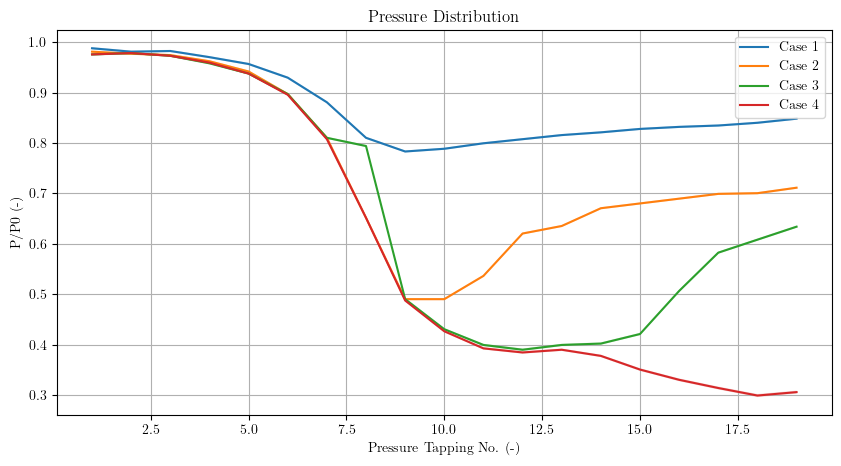

In [5]:
def get_rp(tab):
    dh = (tab[:,2] - tab[:,1]) * 1e-2 # m
    p = P0 - rho_Hg * g * dh

    return p / P0

def get_u_rp(tab):
    h1 = tab[:,1]
    h2 = tab[:,2]

    u_h1 = 0.1 / h1 # accuracy of 1 mm
    u_h2 = 0.1 / h2 # accuracy of 1 mm
    
    u_rp = u_P0 + u_rho_Hg + np.sqrt(u_h1**2 + u_h2**2)
    return u_rp


C1 = np.loadtxt('case1.txt', skiprows=1)
C1_rp, C1_u_rp = get_rp(C1), get_u_rp(C1)
C2 = np.loadtxt('case2.txt', skiprows=1)
C2_rp, C2_u_rp = get_rp(C2), get_u_rp(C2)
C3 = np.loadtxt('case3.txt', skiprows=1)
C3_rp, C3_u_rp = get_rp(C3), get_u_rp(C3)
C4 = np.loadtxt('case4.txt', skiprows=1)
C4_rp, C4_u_rp = get_rp(C4), get_u_rp(C4)

C3_SHOCK_LOCATION = 15

fig,ax = plt.subplots(figsize=(10,5))
x = C1[:,0]
ax.plot(x, C1_rp, label='Case 1')
ax.fill_between(x, C1_rp * (1 - C1_u_rp), C1_rp * (1 + C1_u_rp), alpha=0.2)
ax.plot(x, C2_rp, label='Case 2')
ax.fill_between(x, C2_rp * (1 - C2_u_rp), C2_rp * (1 + C2_u_rp), alpha=0.2)
ax.plot(x, C3_rp , label='Case 3')
ax.fill_between(x, C3_rp * (1 - C3_u_rp), C3_rp * (1 + C3_u_rp), alpha=0.2)
ax.plot(x, C4_rp, label='Case 4')
ax.fill_between(x, C4_rp * (1 - C4_u_rp), C4_rp * (1 + C4_u_rp), alpha=0.2)

plt.xlabel('Pressure Tapping No. (-)')
plt.ylabel('P/P0 (-)')
plt.title('Pressure Distribution')
plt.legend()
plt.grid()
plt.show()

# Mach number graph

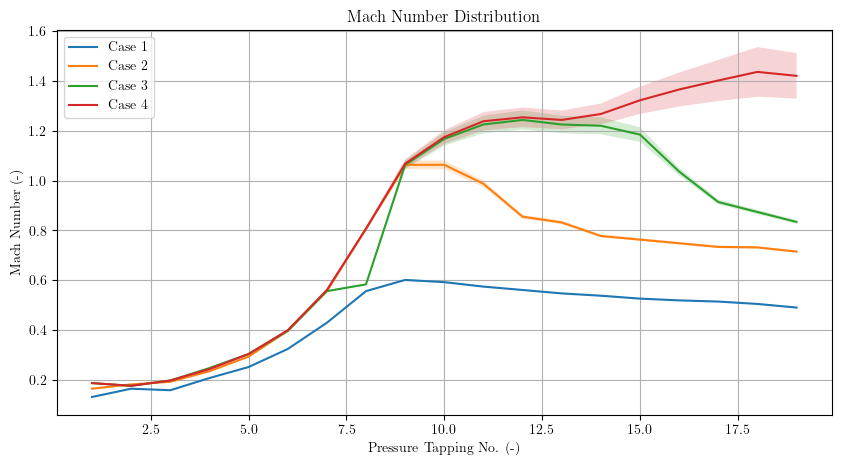

In [6]:

def calc_M(rp):
    # calc mach number from pressure ratio
    g = 1.4
    M2 = (rp ** -((g-1)/g) - 1) * 2 / (g - 1)
    return np.sqrt(M2)

def calc_u_M(rp, u_rp):
    # u_M = u_rp * dM/drp

    g = 1.4
    dM2 = - 2 / g * rp ** (-((g-1)/g) - 1)
    u_M = u_rp * dM2
    return u_M

C1_M, C1_u_M = calc_M(C1_rp), calc_u_M(C1_rp, C1_u_rp)
C2_M, C2_u_M = calc_M(C2_rp), calc_u_M(C2_rp, C2_u_rp)
C3_M, C3_u_M = calc_M(C3_rp), calc_u_M(C3_rp, C3_u_rp)
C4_M, C4_u_M = calc_M(C4_rp), calc_u_M(C4_rp, C4_u_rp)


fig,ax = plt.subplots(figsize=(10,5))
ax.plot(C1[:,0], C1_M, label='Case 1')
ax.fill_between(x, C1_M * (1 - C1_u_M), C1_M * (1 + C1_u_M), alpha=0.2)
ax.plot(C2[:,0], C2_M, label='Case 2')
ax.fill_between(x, C2_M * (1 - C2_u_M), C2_M * (1 + C2_u_M), alpha=0.2)
ax.plot(C3[:,0], C3_M, label='Case 3')
ax.fill_between(x, C3_M * (1 - C3_u_M), C3_M * (1 + C3_u_M), alpha=0.2)
ax.plot(C4[:,0], C4_M, label='Case 4')
ax.fill_between(x, C4_M * (1 - C4_u_M), C4_M * (1 + C4_u_M), alpha=0.2)

plt.xlabel('Pressure Tapping No. (-)')
plt.ylabel('Mach Number (-)')
plt.title('Mach Number Distribution')
plt.legend()
plt.grid()
plt.show()


# Continuation of Case 3 from shock location

In [7]:
import sympy as sp

def Ms_from_M(M):
    g = 1.4
    return np.sqrt((1 + (g - 1) / 2 * M**2) / (g * M**2 - (g - 1) / 2))

def rP0s_from_M(M):
    g = 1.4
    return (((g + 1) / 2 * M**2) / (1 + (g - 1) / 2 * M **2)) ** (g / (g - 1)) * (2 * g / (g + 1) * M**2 - (g - 1) / (g + 1)) ** - (1 / (g - 1))

def P0s_p_from_M(M):
    g = 1.4
    return ((g + 1) / 2 * M**2) ** (g / (g - 1)) * (2 * g / (g + 1) * M**2 - (g - 1) / (g + 1)) ** - (1 / (g - 1))
    
def u_rP0s_from_u_M(Mval, u_M):
    # need analytical derivative of rP0s_from_M
    # using sympy

    M = sp.symbols('M')
    g  = sp.symbols('gamma')
    rP0_expr = (((g + 1) / 2 * M**2) / (1 + (g - 1) / 2 * M **2)) ** (g / (g - 1)) * (2 * g / (g + 1) * M**2 - (g - 1) / (g + 1)) ** - (1 / (g - 1))
    dM_expr = sp.diff(rP0_expr, M)

    tex = sp.latex(dM_expr)
    print(tex)

    # evaluate at M
    dM = dM_expr.evalf(subs={M: Mval, g: 1.4})
    u_rP0s = np.abs(u_M * dM)
    return float(u_rP0s)


u_rp0 = u_rP0s_from_u_M(1.5, 0.1)
print(  u_rp0)

MachNo_before_shock = C4_M[C3_SHOCK_LOCATION]
u_MachNo_before_shock = C4_u_M[C3_SHOCK_LOCATION]

print(f"The Mach Number before the shock is {MachNo_before_shock}")
MachNo_after_shock = Ms_from_M(MachNo_before_shock)
print(f"The Mach Number after the shock is {MachNo_after_shock}")

rPs = rP0s_from_M(MachNo_before_shock)
u_rPs = u_rP0s_from_u_M(MachNo_before_shock, u_MachNo_before_shock)

print(f"The stagnant pressure ratio P0s/P0 is {rPs}")

C3_rp_corrected = C3_rp.copy()
C3_rp_corrected[C3_SHOCK_LOCATION:] /= rPs
C3_u_rp_corrected = C3_u_rp.copy()  
C3_u_rp_corrected[C3_SHOCK_LOCATION:] += u_rPs

C3_rp_corrected[7] = (C3_rp_corrected[6] + C3_rp_corrected[8]) / 2


# find nozzil location
def lerp(x1, x2, y1, y2, x):
    return (y2 - y1) / (x2 - x1) * (x - x1) + y1

def find_throat_location(rp, x, y):
    for i in range(len(rp)):
        if rp[i] < 0.5283:
            break
    # linear interpolation
    return lerp(rp[i], rp[i-1], x[i], x[i-1], 0.5283)

exact_throat_location = find_throat_location(C3_rp_corrected, C3[:,0], C3_rp_corrected)
print(f"Exact nozzil location is {exact_throat_location}")
THROAT_LOCATION = np.ceil(exact_throat_location) - 1


- \frac{4 M \gamma \left(\frac{M^{2} \left(\frac{\gamma}{2} + \frac{1}{2}\right)}{M^{2} \left(\frac{\gamma}{2} - \frac{1}{2}\right) + 1}\right)^{\frac{\gamma}{\gamma - 1}} \left(\frac{2 M^{2} \gamma}{\gamma + 1} - \frac{\gamma - 1}{\gamma + 1}\right)^{- \frac{1}{\gamma - 1}}}{\left(\gamma - 1\right) \left(\gamma + 1\right) \left(\frac{2 M^{2} \gamma}{\gamma + 1} - \frac{\gamma - 1}{\gamma + 1}\right)} + \frac{\gamma \left(\frac{M^{2} \left(\frac{\gamma}{2} + \frac{1}{2}\right)}{M^{2} \left(\frac{\gamma}{2} - \frac{1}{2}\right) + 1}\right)^{\frac{\gamma}{\gamma - 1}} \left(M^{2} \left(\frac{\gamma}{2} - \frac{1}{2}\right) + 1\right) \left(\frac{2 M^{2} \gamma}{\gamma + 1} - \frac{\gamma - 1}{\gamma + 1}\right)^{- \frac{1}{\gamma - 1}} \left(- \frac{2 M^{3} \left(\frac{\gamma}{2} - \frac{1}{2}\right) \left(\frac{\gamma}{2} + \frac{1}{2}\right)}{\left(M^{2} \left(\frac{\gamma}{2} - \frac{1}{2}\right) + 1\right)^{2}} + \frac{2 M \left(\frac{\gamma}{2} + \frac{1}{2}\right)}{M^{2} \left(\fra

# For run 3 of Part 1, determine the strength of the shock in the nozzle from its assumed location.
## Indicate the expected (inviscid) pressure jump across the shock on your graph

In [8]:
def p_p0_from_M(M):
    g = 1.4
    return (1 + (g-1)/2 * M ** 2) ** (-g / (g - 1))

LB = C4_rp[C3_SHOCK_LOCATION]
UB = p_p0_from_M(MachNo_after_shock)


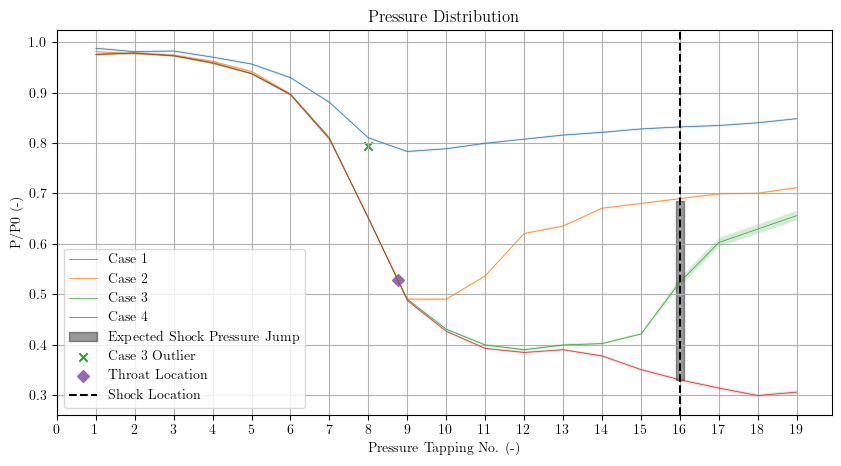

In [9]:

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(C1[:,0], C1_rp, label='Case 1', linewidth = 0.5)
ax.fill_between(C1[:,0], C1_rp * (1 - C1_u_rp), C1_rp * (1 + C1_u_rp), alpha=0.2)
ax.plot(C2[:,0], C2_rp, label='Case 2', linewidth = 0.5)
ax.fill_between(C2[:,0], C2_rp * (1 - C2_u_rp), C2_rp * (1 + C2_u_rp), alpha=0.2)
#ax.plot(C3[:,0], C3_rp, label='Case 3')
ax.plot(C3[:,0], C3_rp_corrected, label='Case 3', linewidth = 0.5)
ax.fill_between(C3[:,0], C3_rp_corrected * (1 - C3_u_rp_corrected), C3_rp_corrected * (1 + C3_u_rp_corrected), alpha=0.2)
ax.plot(C4[:,0], C4_rp, label='Case 4', linewidth=0.5)
ax.fill_between(C4[:,0], C4_rp * (1 - C4_u_rp), C4_rp * (1 + C4_u_rp), alpha=0.2)


width = 0.1
ax.fill_between([C3_SHOCK_LOCATION + 1 - width,
                 C3_SHOCK_LOCATION + 1 + width],
                [LB,LB], [UB,UB], 
                color='black', 
                alpha=0.4,
                label="Expected Shock Pressure Jump")

ax.scatter(C3[7,0], C3_rp[7], label='Case 3 Outlier', color='C2', marker='x')
ax.scatter(exact_throat_location, 0.5283, label='Throat Location', marker='D', c='C4')
ax.axvline(C3_SHOCK_LOCATION + 1, label='Shock Location', c='black', linestyle='--')

plt.xticks(np.arange(0, 20, 1))

plt.xlabel('Pressure Tapping No. (-)')
plt.ylabel('P/P0 (-)')
plt.title('Pressure Distribution')
plt.grid()
plt.legend()

plt.savefig('pressure_ratio_distribution_corrected.png', dpi=300)
plt.show()

# Corrected Mach Diagram

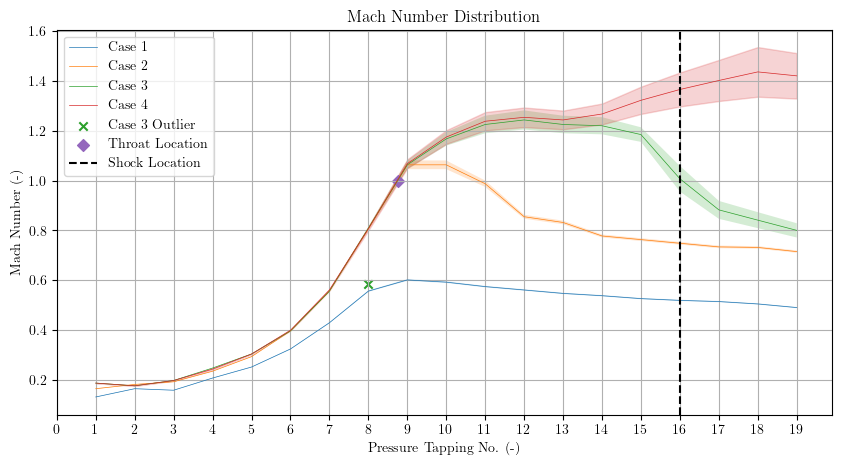

In [10]:

C3_M_corrected = calc_M(C3_rp_corrected)
C3_u_M_corrected = calc_u_M(C3_rp_corrected, C3_u_rp_corrected)

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(C1[:,0], C1_M, label='Case 1', linewidth = 0.5)
ax.fill_between(C1[:,0], C1_M * (1 - C1_u_M), C1_M * (1 + C1_u_M), alpha=0.2)
ax.plot(C2[:,0], C2_M, label='Case 2', linewidth = 0.5)
ax.fill_between(C2[:,0], C2_M * (1 - C2_u_M), C2_M * (1 + C2_u_M), alpha=0.2)
#ax.plot(C3[:,0], C3_M, label='Case 3')
ax.plot(C3[:,0], C3_M_corrected, label='Case 3', linewidth = 0.5)
ax.fill_between(C3[:,0], C3_M_corrected * (1 - C3_u_M_corrected), C3_M_corrected * (1 + C3_u_M_corrected), alpha=0.2)
ax.plot(C4[:,0], C4_M, label='Case 4', linewidth = 0.5)
ax.fill_between(C4[:,0], C4_M * (1 - C4_u_M), C4_M * (1 + C4_u_M), alpha=0.2, color='C3')


ax.scatter(C3[7,0], C3_M[7], label='Case 3 Outlier', color='C2', marker='x')
ax.scatter(exact_throat_location, 1.0, label='Throat Location', marker='D', c='C4')
ax.axvline(C3_SHOCK_LOCATION + 1, label='Shock Location', c='black', linestyle='--')


plt.xticks(np.arange(0, 20, 1))

plt.xlabel('Pressure Tapping No. (-)')
plt.ylabel('Mach Number (-)')
plt.title('Mach Number Distribution')
plt.legend()
plt.grid()
plt.savefig('mach_number_distribution_corrected.png', dpi=300)
plt.show()


In [11]:
THROAT_LOCATION = int(THROAT_LOCATION)
print(f"The Mach Number at the throat is {C1_M[THROAT_LOCATION]:.3f} +- {C1_M[THROAT_LOCATION] * C1_u_M[THROAT_LOCATION]}")
print(f"The Mach Number at the throat is {C2_M[THROAT_LOCATION]:.3f} +- {C2_M[THROAT_LOCATION] * C2_u_M[THROAT_LOCATION]}")
print(f"The Mach Number at the throat is {C3_M_corrected[THROAT_LOCATION]:.3f} +- {C3_M_corrected[THROAT_LOCATION] * C3_u_M_corrected[THROAT_LOCATION]}")
print(f"The Mach Number at the throat is {C4_M[THROAT_LOCATION]:.3f} +- {C4_M[THROAT_LOCATION] * C4_u_M[THROAT_LOCATION]}")
print()
print(f"The Mach Number at the exit is {C1_M[-1]:.3f} +- {C1_u_M[-1]}")
print(f"The Mach Number at the exit is {C2_M[-1]:.3f} +- {C2_u_M[-1]}")
print(f"The Mach Number at the exit is {C3_M_corrected[-1]:.3f} +- {C3_u_M_corrected[-1]}")
print(f"The Mach Number at the exit is {C4_M[-1]:.3f} +- {C4_u_M[-1]}")


The Mach Number at the throat is 0.602 +- -0.003304189177455227
The Mach Number at the throat is 1.063 +- -0.01738467443789352
The Mach Number at the throat is 1.063 +- -0.01738467443789352
The Mach Number at the throat is 1.068 +- -0.017442034476332

The Mach Number at the exit is 0.491 +- -0.00465476873379377
The Mach Number at the exit is 0.715 +- -0.006701402135334223
The Mach Number at the exit is 0.800 +- -0.03568077243814348
The Mach Number at the exit is 1.420 +- -0.06417839448851909


$0.32x^0+-0.48x^1+0.45x^2+-0.20x^3+0.05x^4+-0.01x^5+0.00x^6+-0.00x^7+0.00x^8+-0.00x^9$
$1.38x^0+-2.64x^1+2.08x^2+-0.80x^3+0.17x^4+-0.02x^5+0.00x^6+-0.00x^7+0.00x^8+-0.00x^9$
$1.42x^0+-2.62x^1+2.01x^2+-0.76x^3+0.16x^4+-0.02x^5+0.00x^6+-0.00x^7+0.00x^8+-0.00x^9$
$1.01x^0+-1.71x^1+1.28x^2+-0.47x^3+0.10x^4+-0.01x^5+0.00x^6+-0.00x^7+0.00x^8+-0.00x^9$


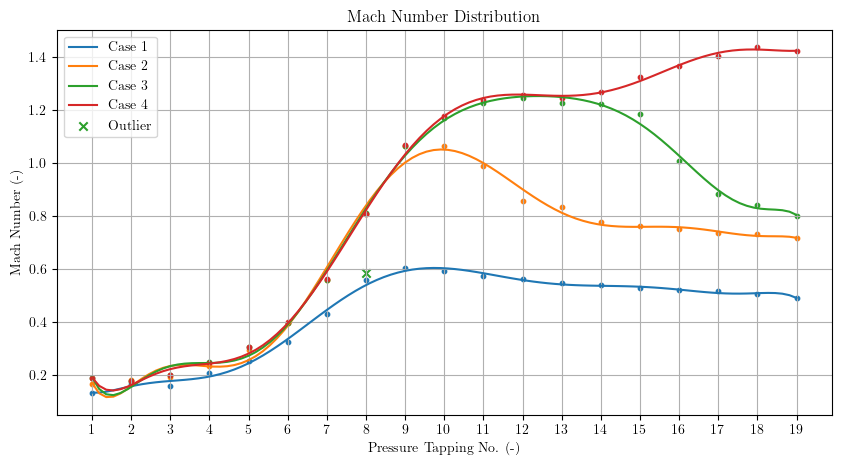

In [12]:

def plot_polyfit(ax, x, y, max_deg, label):

    residuals = []
    for deg in range(max_deg):
        coeff = np.polyfit(x, y, deg)
        p = np.poly1d(coeff)
        xp = np.linspace(x[0], x[-1], 100)
        residual = np.sum((p(x) - y) ** 2)
        residuals.append(residual)

    best_deg = np.argmin(residuals) + 1
    coeff = np.polyfit(x, y, best_deg)
    p = np.poly1d(coeff)
    xp = np.linspace(x[0], x[-1], 100)
    # make tex label
    tex = [f"{c:.2f}x^{i}" for i,c in enumerate(coeff[::-1])]
    tex = '$' + '+'.join(tex) + '$'
    print(tex)
    ax.plot(xp, p(xp), label=label)

fig,ax = plt.subplots(figsize=(10,5))

plt.xticks(np.arange(0, 20, 1))

max_deg = 9
plot_polyfit(ax, C1[:,0], C1_M, max_deg, 'Case 1')
ax.scatter(C1[:,0], C1_M, color='C0', s=10)
plot_polyfit(ax, C2[:,0], C2_M, max_deg, 'Case 2')
ax.scatter(C2[:,0], C2_M, color='C1', s=10)
plot_polyfit(ax, C3[:,0], C3_M_corrected, max_deg, 'Case 3')
ax.scatter(C3[:,0], C3_M_corrected, color='C2', s=10)
plot_polyfit(ax, C4[:,0], C4_M, max_deg, 'Case 4')
ax.scatter(C4[:,0], C4_M, color='C3', s=10)

ax.scatter(C3[7,0], C3_M[7], label='Outlier', color='C2', marker='x')


plt.xlabel('Pressure Tapping No. (-)')
plt.ylabel('Mach Number (-)')
plt.title('Mach Number Distribution')
plt.legend()
plt.grid()
plt.savefig('mach_number_distribution_corrected_polyfit.png', dpi=300)

# not great results

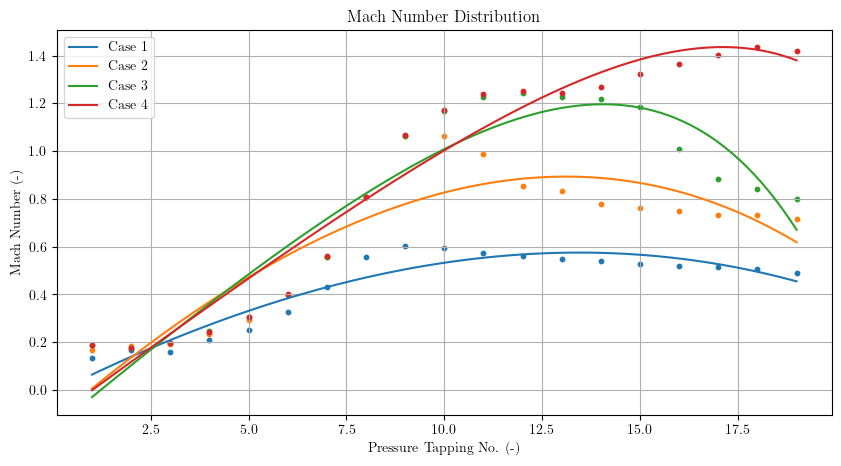

In [13]:
from scipy.optimize import curve_fit

def f(x, a, b, c, d):
    return a + b * x - c * np.exp(-d * x)

def plot_curve_fit(ax, f, x, y, label):
    popt, pcov = curve_fit(f, x, y)
    xp = np.linspace(x[0], x[-1], 100)
    ax.plot(xp, f(xp, *popt), label=label)

fig,ax = plt.subplots(figsize=(10,5))

plot_curve_fit(ax, f, C1[:,0], C1_M, 'Case 1')
ax.scatter(C1[:,0], C1_M, color='C0', s=10)
plot_curve_fit(ax, f, C2[:,0], C2_M, 'Case 2')
ax.scatter(C2[:,0], C2_M, color='C1', s=10)
plot_curve_fit(ax, f, C3[:,0], C3_M_corrected, 'Case 3')
ax.scatter(C3[:,0], C3_M_corrected, color='C2', s=10)
plot_curve_fit(ax, f, C4[:,0], C4_M, 'Case 4')
ax.scatter(C4[:,0], C4_M, color='C3', s=10)

ax.set_xlabel('Pressure Tapping No. (-)')
ax.set_ylabel('Mach Number (-)')
ax.set_title('Mach Number Distribution')
ax.legend()
ax.grid()

plt.show()


# terrible go back to original polyfit

# realised we can do area ratio plot



\frac{2 \left(\frac{2 \left(M^{2} \left(\frac{\gamma}{2} - \frac{1}{2}\right) + 1\right)}{\gamma + 1}\right)^{\frac{\gamma + 1}{2 \gamma - 2}} \left(\frac{\gamma}{2} - \frac{1}{2}\right) \left(\gamma + 1\right)}{\left(2 \gamma - 2\right) \left(M^{2} \left(\frac{\gamma}{2} - \frac{1}{2}\right) + 1\right)} - \frac{\left(\frac{2 \left(M^{2} \left(\frac{\gamma}{2} - \frac{1}{2}\right) + 1\right)}{\gamma + 1}\right)^{\frac{\gamma + 1}{2 \gamma - 2}}}{M^{2}}
\frac{2 \left(\frac{2 \left(M^{2} \left(\frac{\gamma}{2} - \frac{1}{2}\right) + 1\right)}{\gamma + 1}\right)^{\frac{\gamma + 1}{2 \gamma - 2}} \left(\frac{\gamma}{2} - \frac{1}{2}\right) \left(\gamma + 1\right)}{\left(2 \gamma - 2\right) \left(M^{2} \left(\frac{\gamma}{2} - \frac{1}{2}\right) + 1\right)} - \frac{\left(\frac{2 \left(M^{2} \left(\frac{\gamma}{2} - \frac{1}{2}\right) + 1\right)}{\gamma + 1}\right)^{\frac{\gamma + 1}{2 \gamma - 2}}}{M^{2}}
\frac{2 \left(\frac{2 \left(M^{2} \left(\frac{\gamma}{2} - \frac{1}{2}\right) + 1\righ

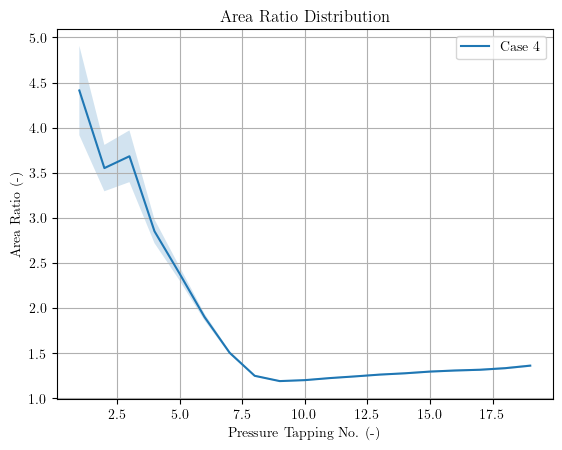

In [14]:

def AAstar(M):
    g = 1.4
    return (1 / M) * ((2 / (g + 1)) * (1 + (g - 1) / 2 * M**2)) ** ((g + 1) / (2 * (g - 1)))

def u_AAstar(Mval, u_M):
    # use sympy
    M = sp.symbols('M')
    g  = sp.symbols('gamma')
    AAstar_expr = (1 / M) * ((2 / (g + 1)) * (1 + (g - 1) / 2 * M**2)) ** ((g + 1) / (2 * (g - 1)))

    dM_expr = sp.diff(AAstar_expr, M)
    tex = sp.latex(dM_expr)
    print(tex)

    # evaluate at M
    out = np.zeros_like(Mval)
    for i in range(len(Mval)):
        out[i] = dM_expr.evalf(subs={M: Mval[i], g: 1.4})

    u_AAstar = np.abs(u_M * out)
    return u_AAstar

C1_AAstar, C1_u_AAstar = AAstar(C1_M), u_AAstar(C1_M, C1_u_M)
C2_AAstar, C2_u_AAstar = AAstar(C2_M), u_AAstar(C2_M, C2_u_M)
C3_AAstar, C3_u_AAstar = AAstar(C3_M_corrected), u_AAstar(C3_M_corrected, C3_u_M_corrected)
C4_AAstar, C4_u_AAstar = AAstar(C1_M), u_AAstar(C1_M, C1_u_M)


fig,ax = plt.subplots()
"""
ax.plot(C1[:,0], C1_AAstar, label='Case 1')
ax.fill_between(x, C1_AAstar * (1 - C1_u_AAstar), C1_AAstar * (1 + C1_u_AAstar), alpha=0.2)
ax.plot(C2[:,0], C2_AAstar, label='Case 2')
ax.fill_between(x, C2_AAstar * (1 - C2_u_AAstar), C2_AAstar * (1 + C2_u_AAstar), alpha=0.2)
ax.plot(C3[:,0], C3_AAstar, label='Case 3')
ax.fill_between(x, C3_AAstar * (1 - C3_u_AAstar), C3_AAstar * (1 + C3_u_AAstar), alpha=0.2)
ax.plot(C4[:,0], C4_AAstar, label='Case 4')
ax.fill_between(x, C4_AAstar * (1 - C4_u_AAstar), C4_AAstar * (1 + C4_u_AAstar), alpha=0.2)
"""
ax.plot(C4[:,0], C4_AAstar, label='Case 4')
ax.fill_between(x, C4_AAstar * (1 - C4_u_AAstar), C4_AAstar * (1 + C4_u_AAstar), alpha=0.2)



plt.xlabel('Pressure Tapping No. (-)')
plt.ylabel('Area Ratio (-)')

plt.title('Area Ratio Distribution')
plt.legend()
plt.grid()

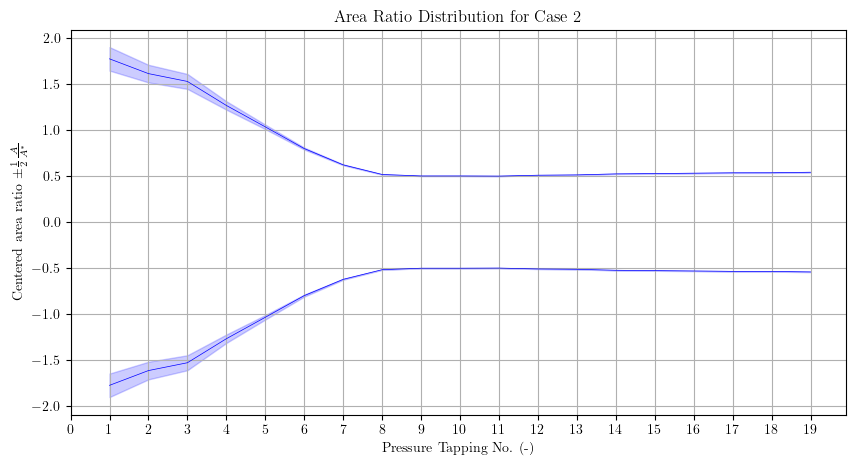

In [15]:
d0 = 0
width = 1 #mm
Astar = 24 # mm^2

def plot_nozzle_profile(ax, x, rA, u_rA):
    Astar = 1
    d = Astar * rA / width
    u_d = u_rA # + 1 / Astar

    ax.plot(x, + d / 2, color = 'blue', linewidth=0.5)
    ax.plot(x, - d / 2, color = 'blue', linewidth=0.5)
    ax.fill_between(x, - d / 2 * (1 - u_d), - d / 2 * (1 + u_d), alpha=0.2, color='blue')
    ax.fill_between(x, + d / 2 * (1 - u_d), + d / 2 * (1 + u_d), alpha=0.2, color='blue')

fig,ax = plt.subplots(figsize=(10,5))

plot_nozzle_profile(ax, C2[:,0], C2_AAstar, C2_u_AAstar)

plt.xticks(np.arange(0, 20, 1))

ax.set_xlabel('Pressure Tapping No. (-)')
ax.set_ylabel('Centered area ratio $\pm \\frac{1}{2}\\frac{A}{A^*}$')
ax.set_title('Area Ratio Distribution for Case 2')
ax.grid()
plt.savefig('area_ratio_distribution.png', dpi=300)
plt.show()


Using your measurement of mass flow in Part 1, calculate the cross-sectional areas of the throat and at
the nozzle exit for each run. In the case of Run 3 you need to first determine the expected stagnation
pressure drop through the shock wave before calculating the nozzle exit area. You should then attempt
to explain any differences you may find between the results of the different runs (note that the actual
cross-sectional area at the throat of the nozzle is approximately 24 mm2).

In [16]:
T0 = 23.01 + 273.15 # K

def T_T0_from_M(M):
    g = 1.4
    return (1 + (g - 1) / 2 * M**2) ** -1

def dimensionless_mfr(M):
    g = 1.4
    return g / np.sqrt(g - 1) * M * (1 + (g - 1) / 2 * M**2) ** (- (g + 1) / (2 * (g - 1)))

def u_dimensionless_mfr(Mval, u_M):
    g = sp.symbols('gamma')
    M = sp.symbols('M')

    expr = g / sp.sqrt(g - 1) * M * (1 + (g - 1) / 2 * M**2) ** (- (g + 1) / (2 * (g - 1)))
    dM_expr = sp.diff(expr, M)
    tex = sp.latex(dM_expr)
    print(tex)

    # evaluate at M
    d_dim_mfr = dM_expr.evalf(subs={M: Mval, g: 1.4})

    return np.abs(u_M * d_dim_mfr)

Cp = 1005 # J/(kg K) specific heat of air

A1_T = C1_md * np.sqrt(Cp * T0) / (P0 * dimensionless_mfr(C1_M[THROAT_LOCATION])) * 1e3
A2_T = C2_md * np.sqrt(Cp * T0) / (P0 * dimensionless_mfr(C2_M[THROAT_LOCATION])) * 1e3
A3_T = C3_md * np.sqrt(Cp * T0) / (P0 * dimensionless_mfr(C3_M_corrected[THROAT_LOCATION])) * 1e3
A4_T = C4_md * np.sqrt(Cp * T0) / (P0 * dimensionless_mfr(C4_M[THROAT_LOCATION])) * 1e3

u_A1_T = C1_u_md + u_dimensionless_mfr(C1_M[THROAT_LOCATION], C1_u_M[THROAT_LOCATION]) + u_P0 + u_T0
u_A2_T = C2_u_md + u_dimensionless_mfr(C2_M[THROAT_LOCATION], C2_u_M[THROAT_LOCATION]) + u_P0 + u_T0
u_A3_T = C3_u_md + u_dimensionless_mfr(C3_M_corrected[THROAT_LOCATION], C3_u_M_corrected[THROAT_LOCATION]) + u_P0 + u_T0
u_A4_T = C4_u_md + u_dimensionless_mfr(C4_M[THROAT_LOCATION], C4_u_M[THROAT_LOCATION]) + u_P0 + u_T0

print(f"The area of the throat for case 1 is {A1_T} +- {A1_T * u_A1_T} m^2")
print(f"The area of the throat for case 2 is {A2_T} +- {A2_T * u_A2_T} m^2")
print(f"The area of the throat for case 3 is {A3_T} +- {A3_T * u_A3_T} m^2")
print(f"The area of the throat for case 4 is {A4_T} +- {A4_T * u_A4_T} m^2")


\frac{2 M^{2} \gamma \left(- \gamma - 1\right) \left(\frac{\gamma}{2} - \frac{1}{2}\right) \left(M^{2} \left(\frac{\gamma}{2} - \frac{1}{2}\right) + 1\right)^{\frac{- \gamma - 1}{2 \gamma - 2}}}{\sqrt{\gamma - 1} \cdot \left(2 \gamma - 2\right) \left(M^{2} \left(\frac{\gamma}{2} - \frac{1}{2}\right) + 1\right)} + \frac{\gamma \left(M^{2} \left(\frac{\gamma}{2} - \frac{1}{2}\right) + 1\right)^{\frac{- \gamma - 1}{2 \gamma - 2}}}{\sqrt{\gamma - 1}}
\frac{2 M^{2} \gamma \left(- \gamma - 1\right) \left(\frac{\gamma}{2} - \frac{1}{2}\right) \left(M^{2} \left(\frac{\gamma}{2} - \frac{1}{2}\right) + 1\right)^{\frac{- \gamma - 1}{2 \gamma - 2}}}{\sqrt{\gamma - 1} \cdot \left(2 \gamma - 2\right) \left(M^{2} \left(\frac{\gamma}{2} - \frac{1}{2}\right) + 1\right)} + \frac{\gamma \left(M^{2} \left(\frac{\gamma}{2} - \frac{1}{2}\right) + 1\right)^{\frac{- \gamma - 1}{2 \gamma - 2}}}{\sqrt{\gamma - 1}}
\frac{2 M^{2} \gamma \left(- \gamma - 1\right) \left(\frac{\gamma}{2} - \frac{1}{2}\right) \left(M

# Now nozzle exit area

In [17]:

A1_E = C1_md * np.sqrt(Cp * T0) / (P0 * dimensionless_mfr(C1_M[-1])) * 1e3
A2_E = C2_md * np.sqrt(Cp * T0) / (P0 * dimensionless_mfr(C2_M[-1])) * 1e3
A3_E = C3_md * np.sqrt(Cp * T0) / (P0 * dimensionless_mfr(C3_M_corrected[-1])) * 1e3
A4_E = C4_md * np.sqrt(Cp * T0) / (P0 * dimensionless_mfr(C4_M[-1])) * 1e3

u_A1_E = C1_u_md + u_dimensionless_mfr(C1_M[-1], C1_u_M[-1]) + u_P0 + u_T0
u_A2_E = C2_u_md + u_dimensionless_mfr(C2_M[-1], C2_u_M[-1]) + u_P0 + u_T0
u_A3_E = C3_u_md + u_dimensionless_mfr(C3_M_corrected[-1], C3_u_M_corrected[-1]) + u_P0 + u_T0
u_A4_E = C4_u_md + u_dimensionless_mfr(C4_M[-1], C4_u_M[-1]) + u_P0 + u_T0

print(f"The area of the exit for case 1 is {A1_E} +- {A1_E * u_A1_E} m^2")
print(f"The area of the exit for case 2 is {A2_E} +- {A2_E * u_A2_E} m^2")
print(f"The area of the exit for case 3 is {A3_E} +- {A3_E * u_A3_E} m^2")
print(f"The area of the exit for case 4 is {A4_E} +- {A4_E * u_A4_E} m^2")

\frac{2 M^{2} \gamma \left(- \gamma - 1\right) \left(\frac{\gamma}{2} - \frac{1}{2}\right) \left(M^{2} \left(\frac{\gamma}{2} - \frac{1}{2}\right) + 1\right)^{\frac{- \gamma - 1}{2 \gamma - 2}}}{\sqrt{\gamma - 1} \cdot \left(2 \gamma - 2\right) \left(M^{2} \left(\frac{\gamma}{2} - \frac{1}{2}\right) + 1\right)} + \frac{\gamma \left(M^{2} \left(\frac{\gamma}{2} - \frac{1}{2}\right) + 1\right)^{\frac{- \gamma - 1}{2 \gamma - 2}}}{\sqrt{\gamma - 1}}
\frac{2 M^{2} \gamma \left(- \gamma - 1\right) \left(\frac{\gamma}{2} - \frac{1}{2}\right) \left(M^{2} \left(\frac{\gamma}{2} - \frac{1}{2}\right) + 1\right)^{\frac{- \gamma - 1}{2 \gamma - 2}}}{\sqrt{\gamma - 1} \cdot \left(2 \gamma - 2\right) \left(M^{2} \left(\frac{\gamma}{2} - \frac{1}{2}\right) + 1\right)} + \frac{\gamma \left(M^{2} \left(\frac{\gamma}{2} - \frac{1}{2}\right) + 1\right)^{\frac{- \gamma - 1}{2 \gamma - 2}}}{\sqrt{\gamma - 1}}
\frac{2 M^{2} \gamma \left(- \gamma - 1\right) \left(\frac{\gamma}{2} - \frac{1}{2}\right) \left(M